In [48]:

import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

from datasets import load_dataset

import torch
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from diffusers import DDPMScheduler
from diffusers import DDPMPipeline




def show_images(x):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im


def make_grid(images, size=64):
    """Given a list of PIL images, stack them together into a line for easy viewing"""
    output_im = Image.new("RGB", (size * len(images), size))
    for i, im in enumerate(images):
        output_im.paste(im.resize((size, size)), (i * size, 0))
    return output_im


# Mac users may need device = 'mps' (untested)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)


## References 
# https://github.com/huggingface/diffusion-models-class/tree/main/unit1#what-are-diffusion-models
# https://github.com/huggingface/diffusion-models-class/blob/main/unit1/01_introduction_to_diffusers.ipynb
# https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/training_example.ipynb 




cuda


## Download a training dataset

In [27]:
dataset = load_dataset("huggan/smithsonian_butterflies_subset", split="train")

KeyboardInterrupt: 

In [28]:

# Or load images from a local folder
# dataset = load_dataset("imagefolder", data_dir="path/to/folder")

# We'll train on 32-pixel square images, but you can try larger sizes too
image_size = 32
# You can lower your batch size if you're running out of GPU memory
batch_size = 64

# Define data augmentations
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),  # Resize
        transforms.RandomHorizontalFlip(),  # Randomly flip (data augmentation)
        transforms.ToTensor(),  # Convert to tensor (0, 1)
        transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1)
    ]
)


def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}


dataset.set_transform(transform)

# Create a dataloader from the dataset to serve up the transformed images in batches
train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

X shape: torch.Size([8, 3, 32, 32])


/tmp/ipykernel_32077/2372537353.py:4: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  show_images(xb).resize((8 * 64, 64), resample=Image.NEAREST)


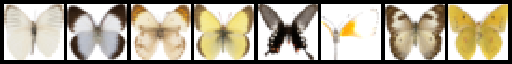

In [32]:
xb = next(iter(train_dataloader))["images"].to(device)[:8]

print("X shape:", xb.shape)
show_images(xb).resize((8 * 64, 64), resample=Image.NEAREST)



## Define the Scheduler

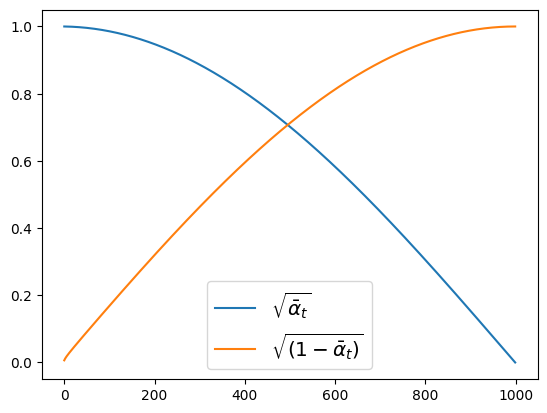

In [39]:
# from diffusers import DDPMPipeline

### Default linear scheduler 
# noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

### One with too little noise added:
# noise_scheduler = DDPMScheduler(num_train_timesteps=200, beta_start=0.01, beta_end=0.001)
# noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_start=0.001, beta_end=0.004)

### The 'cosine' schedule, which may be better for small image sizes:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");



Noisy X shape torch.Size([8, 3, 32, 32])


/tmp/ipykernel_32077/1445576550.py:5: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  show_images(noisy_xb).resize((8 * 64, 64), resample=Image.NEAREST)


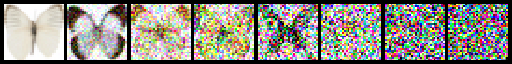

In [40]:
timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb)
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print("Noisy X shape", noisy_xb.shape)
show_images(noisy_xb).resize((8 * 64, 64), resample=Image.NEAREST)

## Define the Model

In [41]:


from diffusers import UNet2DModel

# Create a model
model = UNet2DModel(
    sample_size=image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(64, 128, 128, 256),  # More channels -> more parameters
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",  # a regular ResNet upsampling block
    ),
)
model.to(device);



In [42]:
with torch.no_grad():
    model_prediction = model(noisy_xb, timesteps).sample
model_prediction.shape



torch.Size([8, 3, 32, 32])

## Training Loop

In [46]:


# Training loop
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)

losses = []
# epoch_number = 30 from the example
epoch_number = 30 

for epoch in range(epoch_number):
    for step, batch in enumerate(train_dataloader):
        clean_images = batch["images"].to(device)
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(
            0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device
        ).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        # Calculate the loss
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)
        losses.append(loss.item())

        # Update the model parameters with the optimizer
        optimizer.step()
        optimizer.zero_grad()

    if (epoch + 1) % 5 == 0:
        loss_last_epoch = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
        print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")



Epoch:5, loss: 0.09568800497800112
Epoch:10, loss: 0.07892938004806638
Epoch:15, loss: 0.06917114253155887
Epoch:20, loss: 0.06770972115918994
Epoch:25, loss: 0.06170325307175517
Epoch:30, loss: 0.055421049473807216


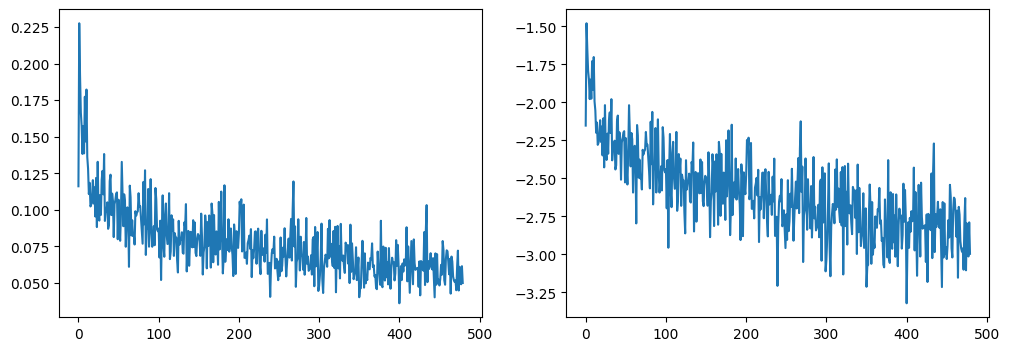

In [49]:


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()



## Generate Images

### Option 1: Creating a pipeline

In [50]:

image_pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler)

In [58]:
pipeline_output = image_pipe()


  0%|          | 0/1000 [00:00<?, ?it/s]

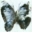

In [59]:
pipeline_output.images[0]

In [60]:
image_pipe.save_pretrained("my_pipeline")

In [67]:
ls -la my_pipeline/

total 20
drwxrwxr-x 4 mxochicale mxochicale 4096 Jan 13 18:25 ./
drwxrwxr-x 4 mxochicale mxochicale 4096 Jan 13 18:25 ../
-rw-rw-r-- 1 mxochicale mxochicale  181 Jan 13 18:25 model_index.json
drwxrwxr-x 2 mxochicale mxochicale 4096 Jan 13 18:25 scheduler/
drwxrwxr-x 2 mxochicale mxochicale 4096 Jan 13 18:25 unet/


### Option 2: Writing a Sampling Loop

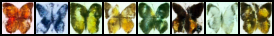

In [68]:


# Random starting point (8 random images):
sample = torch.randn(8, 3, 32, 32).to(device)

for i, t in enumerate(noise_scheduler.timesteps):

    # Get model pred
    with torch.no_grad():
        residual = model(sample, t).sample

    # Update sample with step
    sample = noise_scheduler.step(residual, t, sample).prev_sample

show_images(sample)



## Step 7: Push your model to the Hub?